In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import cycle
from itertools import chain
from scipy import stats
from numpy import mean
from numpy import std
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import math
import os
import time
from tensorflow.keras.models import load_model
from keras import backend as K
from keras.utils.layer_utils import count_params

from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Flatten, Dense,MaxPooling2D ,Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')
print('Keras Version', keras.__version__)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIOD = 80
WINDOW = 40
# originally used to fine tune the values, but that is now being done in a loop with several different dimension sizes.
tuner = 1

Keras Version 2.2.4-tf


In [ ]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [ ]:
def show_basic_dataframe(dataframe):
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i' % (dataframe.shape[0]))

In [ ]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    fig.savefig(activity+'_x-y-z-axis')
    plt.show()

In [ ]:
def plot_axis(ax,x,y,title):
    ax.plot(x,y,'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y)-np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [ ]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0,how='any',inplace=True)
    return df


In [ ]:
def read_dir(dir_path):
    df = []
    for f_name in os.listdir(dir_path):
        if f_name.endswith('.txt'):
            df1= read_data(dir_path+f_name)
            df.append(df1)

    return df

In [ ]:
#df.to_csv('full_dataset_with_18_act.csv')
df = pd.read_csv('full_dataset_with_18_act.csv')
show_basic_dataframe(df)
print(df.head(10))
# fig = plt.figure()

# # df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
# # plt.show()
# # fig.savefig('trainingexamplebyacitivty.png')
# # df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')

# # plt.show()
# # fig.savefig('trainingexamplesbyusers.png')

Number of columns in the dataframe: 7
Number of rows in the dataframe: 4804403
   Unnamed: 0  user-id activity        timestamp  x-axis  y-axis  z-axis
0           0     1600        A  252207666810782    -0.4     8.8     1.1
1           1     1600        A  252207717164786    -0.9     9.8     1.0
2           2     1600        A  252207767518790     2.0    11.1     2.6
3           3     1600        A  252207817872794     0.5    12.7     0.2
4           4     1600        A  252207868226798    -2.2    13.9    -4.4
5           5     1600        A  252207918580802    -4.3    13.4    -0.7
6           6     1600        A  252207968934806    -0.3    13.3    -0.2
7           7     1600        A  252208019288809     1.6     9.5    -0.0
8           8     1600        A  252208069642813    -0.3     5.3     0.3
9           9     1600        A  252208119996817    -1.8     3.7     1.4


In [ ]:
def labelenocoder(df_label):
    for activity in np.unique(df_label['activity']):
        subset = df_label[df_label['activity'] == activity][:180]
        plot_activity(activity,subset)

    LABEL = 'ActivityEncoded'
    le = preprocessing.LabelEncoder()

    df_label[LABEL] = le.fit_transform(df_label['activity'].values.ravel())
    return le

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_names):
    FEATURES = 3

    segments = []
    labels = []

    for i in range(0,len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        label = stats.mode(df[label_names][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
def spliting_dataset(df_base,fixed_set=-1):
    if(fixed_set!=-1):
        df_test = df_base[df_base['user-id'] > fixed_set ]
        df_train = df_base[df_base['user-id'] <= fixed_set ]
    else:
        df_train = df_base

    pd.options.mode.chained_assignment = None
    df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
    df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
    df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

    df_train = df_train.round({'x-axis': 4, 'y-axis':4, 'z-axis': 4})

    X_train, y_train = create_segments_and_labels(df_train, TIME_PERIOD, WINDOW, LABEL)

    print('X_train Shape:', X_train.shape)
    print(X_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    input_shape = (80*3)
    x_train = X_train.reshape(X_train.shape[0], input_shape)
    # print('x_train shape:', x_train)
    print('input_shape:', input_shape)
    samps, secs, accel = X_train.shape
    red_dim = secs * accel
    
    return X_train,y_train

In [ ]:
def y_train_set(y_train,y_test,y_val,number_labels=9):
    y_train_hot = tf.keras.utils.to_categorical(y_train, number_labels)
    print('New y_train shape: ', y_train_hot.shape)
    y_test_hot = tf.keras.utils.to_categorical(y_test, number_labels)
    print('New y_train shape: ', y_test_hot.shape)
    y_val_hot = tf.keras.utils.to_categorical(y_val, number_labels)
    print('New y_train shape: ', y_val_hot.shape)
    return y_train_hot, y_test_hot,y_val_hot

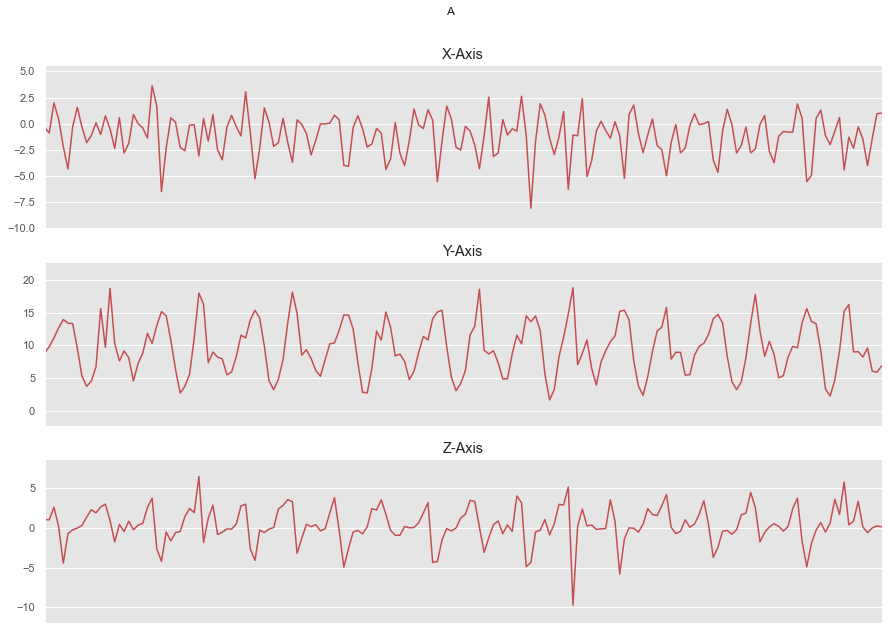

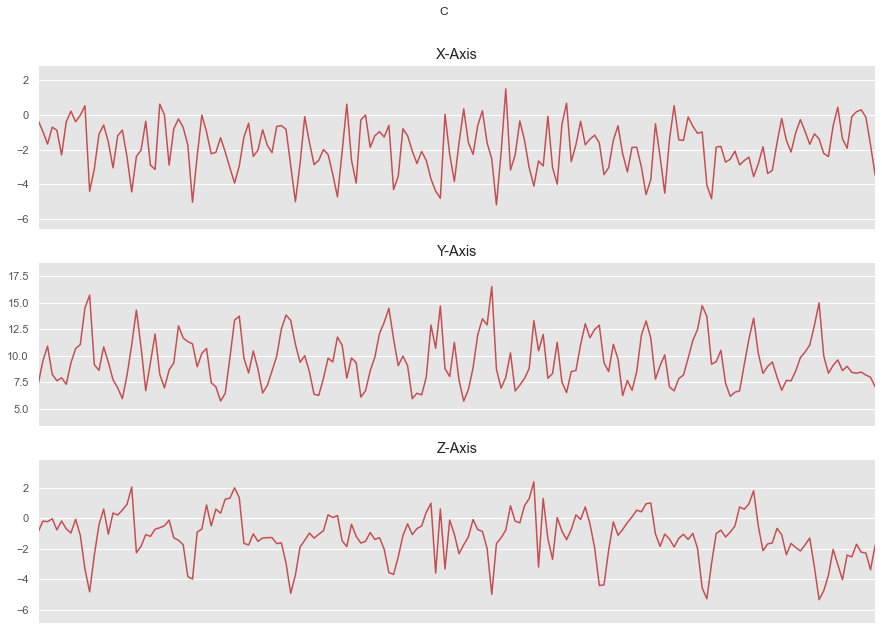

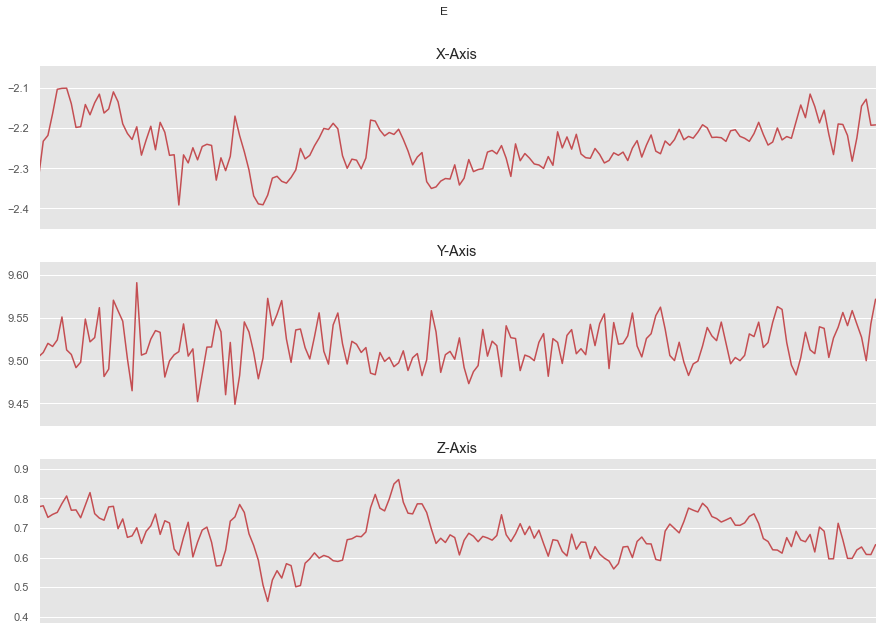

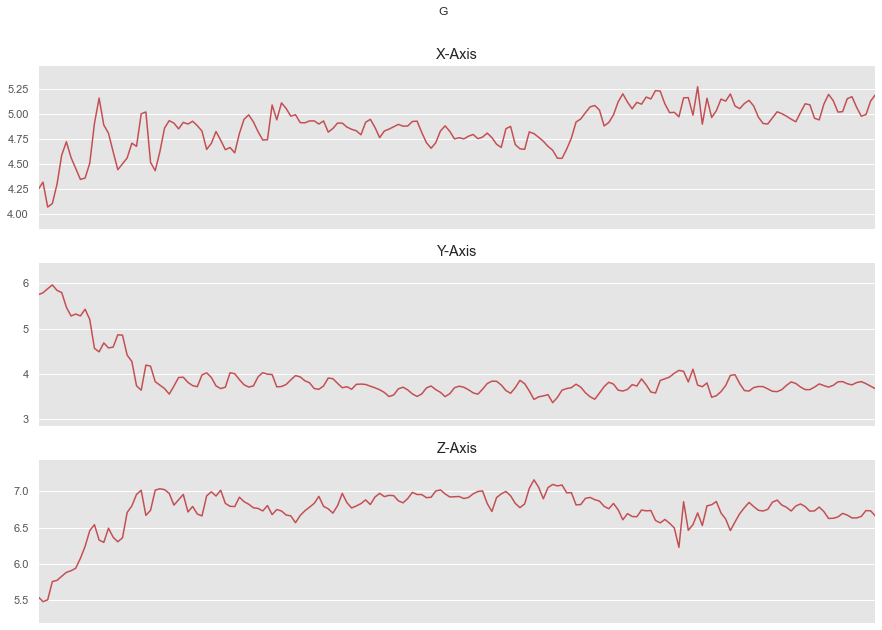

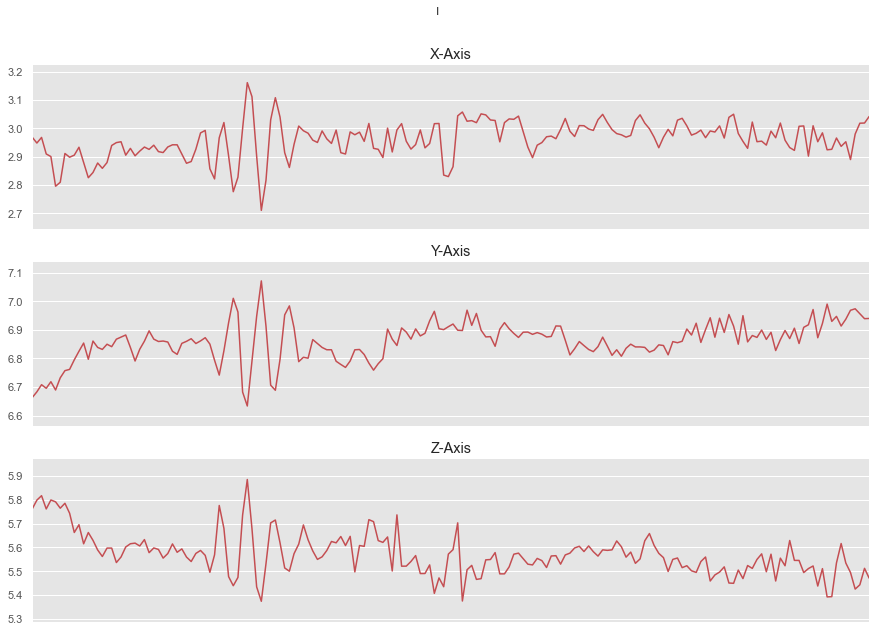

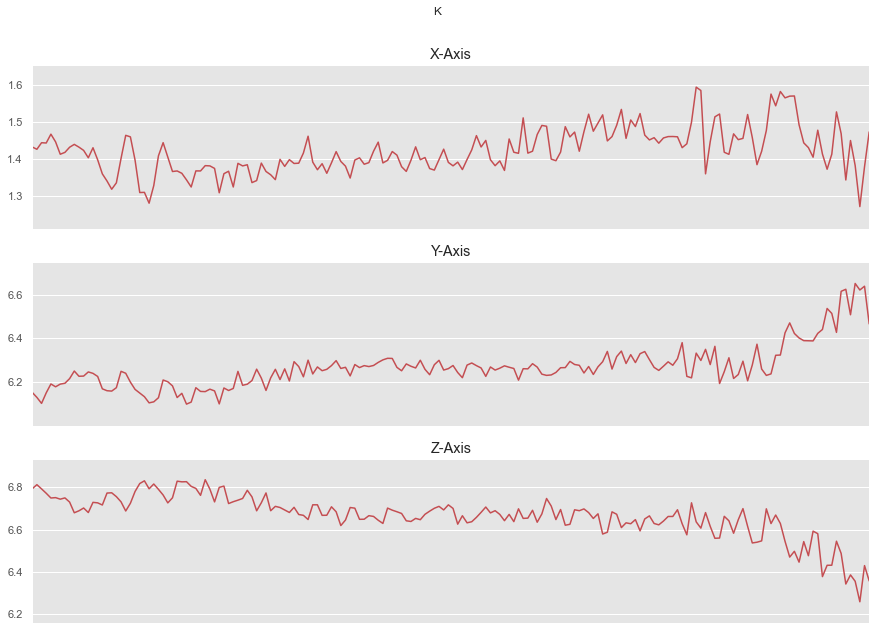

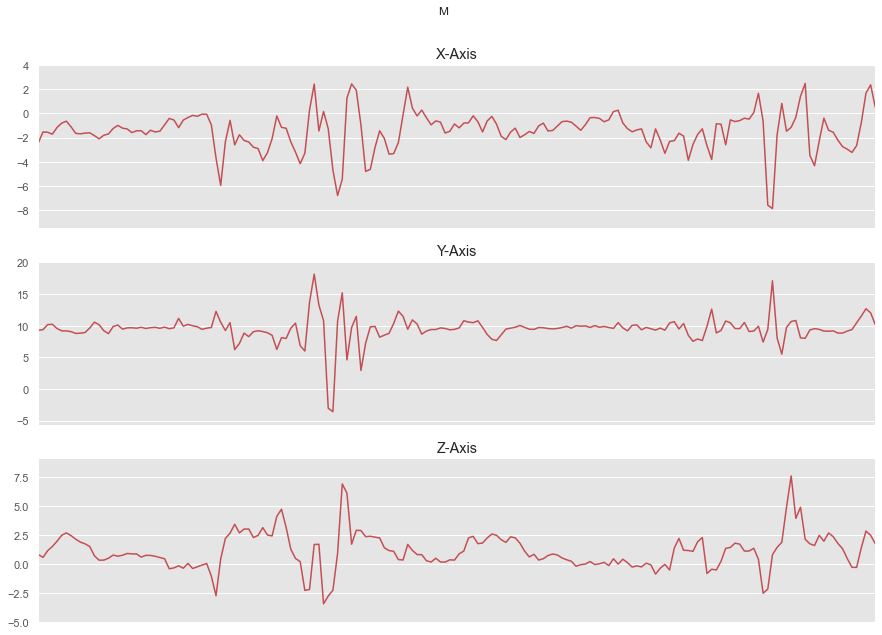

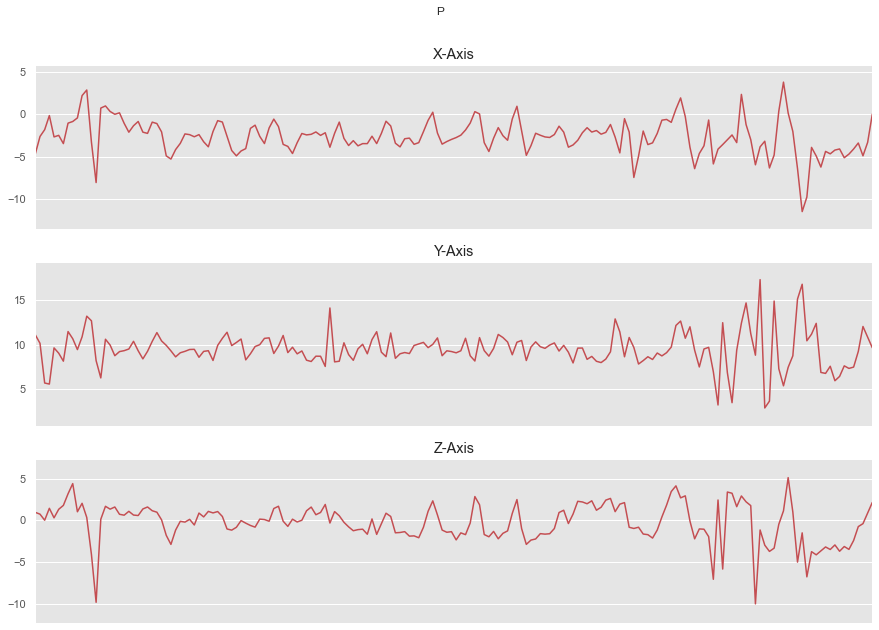

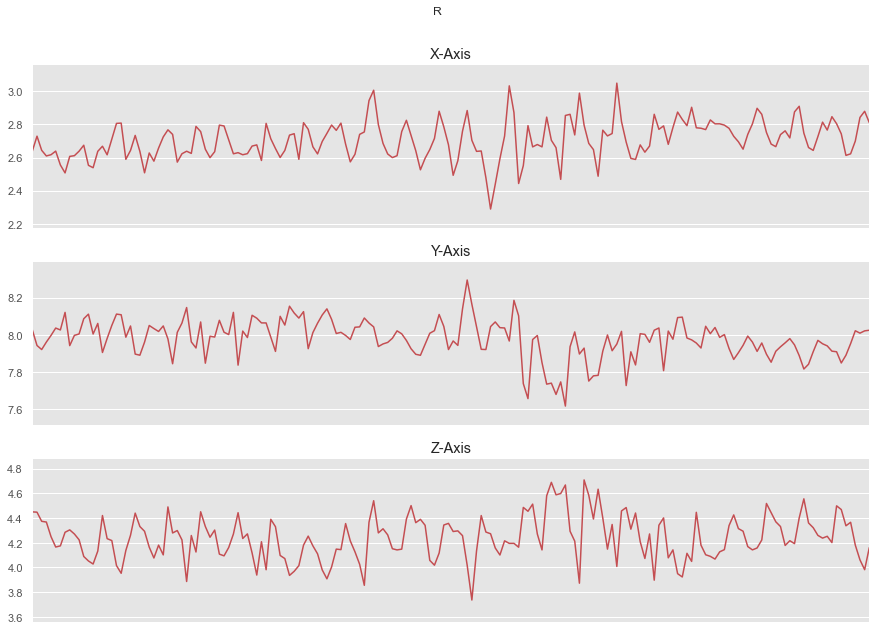

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
base_activity= ['A','C','E','G','I','K','M','P','R']


df_base = df[  (df['activity']=='A') | (df['activity']=='C') | (df['activity']=='E')
             | (df['activity']=='G') | (df['activity']=='I') | (df['activity']=='K')
             | (df['activity']=='M') | (df['activity']=='P') | (df['activity']=='R')]
le = labelenocoder(df_base)

In [ ]:
LABEL = 'ActivityEncoded'
X_train,y_train = spliting_dataset(df_base)
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0,  stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,  random_state = 0, stratify = y_train)

X_train Shape: (61018, 80, 3)
61018 training samples
y_train shape:  (61018,)
input_shape: 240
['A', 'C', 'E', 'G', 'I', 'K', 'M', 'P', 'R']


In [ ]:
y_train_hot,y_test_hot,y_val_hot =  y_train_set(y_train,y_test,y_val)

New y_train shape:  (39051, 9)
New y_train shape:  (12204, 9)
New y_train shape:  (9763, 9)


In [ ]:
model = keras.Sequential()
model.add(LSTM(256,input_shape=(80,3)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))

model.add(Dense(9, activation='softmax'))

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        if logs.get('accuracy') >= 9e-1:

            self.model.stop_training = True


In [ ]:
callback = CustomCallback()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
start = time.time()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train,y_train_hot,batch_size=64,validation_data=(X_val, y_val_hot),verbose=1,
                    callbacks=[callback],epochs=100)
stop= time.time()

Train on 39051 samples, validate on 9763 samples
Epoch 1/100
39051/39051 [==============================] - 100s 3ms/sample - loss: 1.7946 - accuracy: 0.2595 - val_loss: 1.7540 - val_accuracy: 0.2628
Epoch 2/100
39051/39051 [==============================] - 99s 3ms/sample - loss: 1.7755 - accuracy: 0.2728 - val_loss: 1.7341 - val_accuracy: 0.2895
Epoch 3/100
39051/39051 [==============================] - 100s 3ms/sample - loss: 1.5930 - accuracy: 0.3369 - val_loss: 1.3783 - val_accuracy: 0.4302
Epoch 4/100
39051/39051 [==============================] - 100s 3ms/sample - loss: 1.3741 - accuracy: 0.4240 - val_loss: 1.3390 - val_accuracy: 0.4431
Epoch 5/100
39051/39051 [==============================] - 102s 3ms/sample - loss: 1.2963 - accuracy: 0.4582 - val_loss: 1.2316 - val_accuracy: 0.4840
Epoch 6/100
39051/39051 [==============================] - 103s 3ms/sample - loss: 1.2325 - accuracy: 0.4898 - val_loss: 1.3602 - val_accuracy: 0.4358
Epoch 7/100
39051/39051 [=====================

In [ ]:
base_time=stop-start
base_time

8548.384828805923

In [ ]:
model.save('base_model_lstm.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


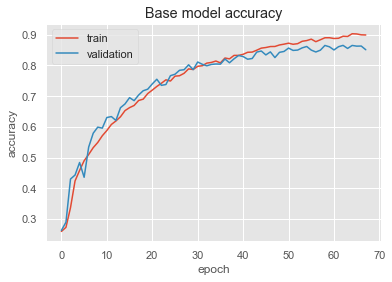

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('Base model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('base_model_accuracy_lstm.png')
plt.show()

In [ ]:
def eval_standalone_model(X_train, X_test, y_train, y_test, X_val, y_val , n_repeats=1):
    scores = list()
    times = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        start = time.time()
        model.fit(X_train,y_train_hot,batch_size=64,validation_data=(X_val, y_val_hot),verbose=1,
                    callbacks=[callback],epochs=100)
        # evaluate model on test dataset
        stop = time.time()
        _, test_acc = model.evaluate(X_test, y_test, verbose=0)
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

In [ ]:
def eval_transfer_model(X_train, X_test, y_train, y_test, n_fixed, n_repeats=1,number_of_layers=[]):
    scores = list()
    times = list()
    for _ in range(n_repeats):
    # load model
        model = tf.keras.models.load_model('base_model_lstm.h5')
        # mark layer weights as fixed or not trainable
        for i in range(number_of_layers):
            model.layers[i].trainable = False
        # re-compile model
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        model.compile(optimizer=Adam(learning_rate = 0.001, decay = 1e-6), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
        # fit model on train dataset
        start = time.time()
        model.fit(X_train, y_train, epochs=50, verbose=0)
        stop = time.time()
        # evaluate model on test dataset
        _, test_acc = model.evaluate( X_test, y_test, verbose=0,callbacks=[callback])
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

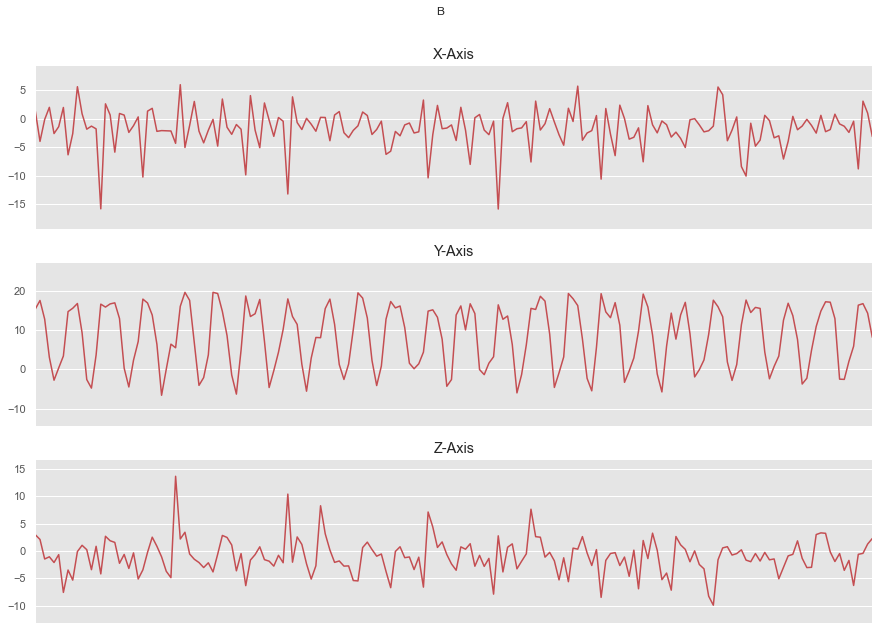

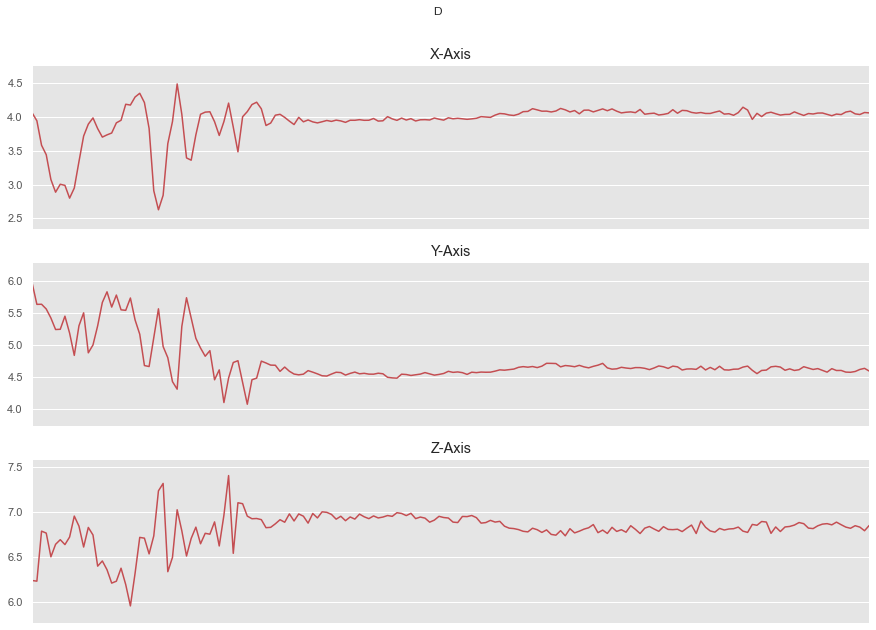

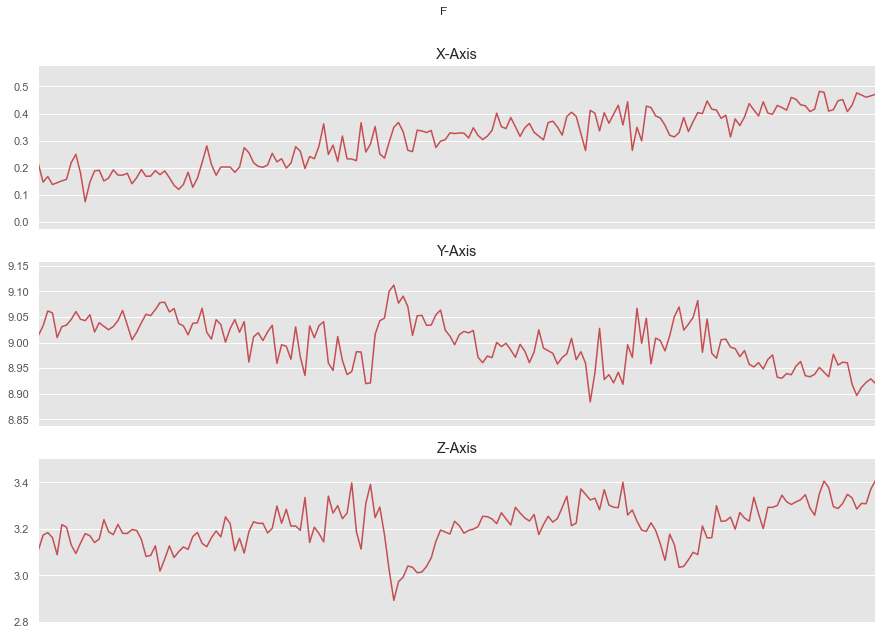

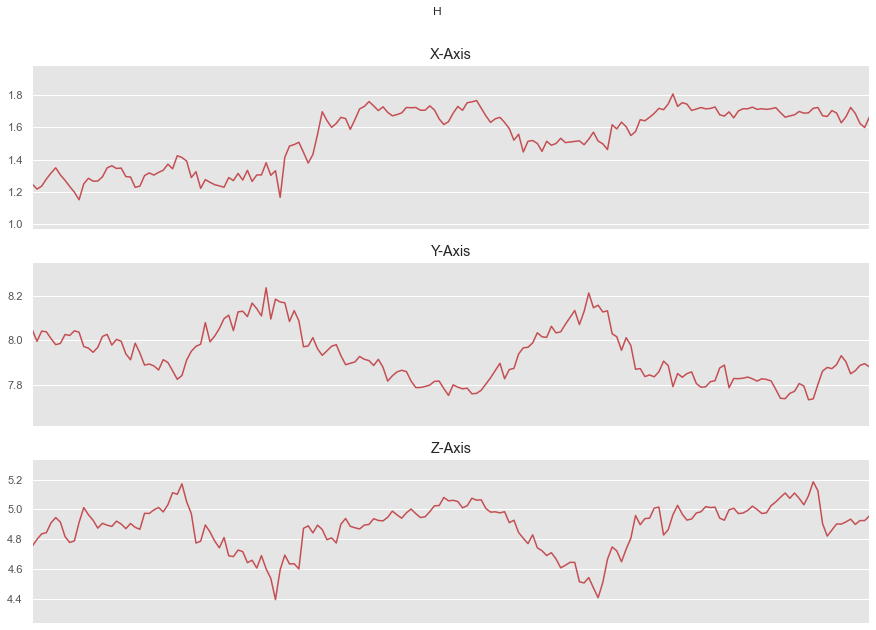

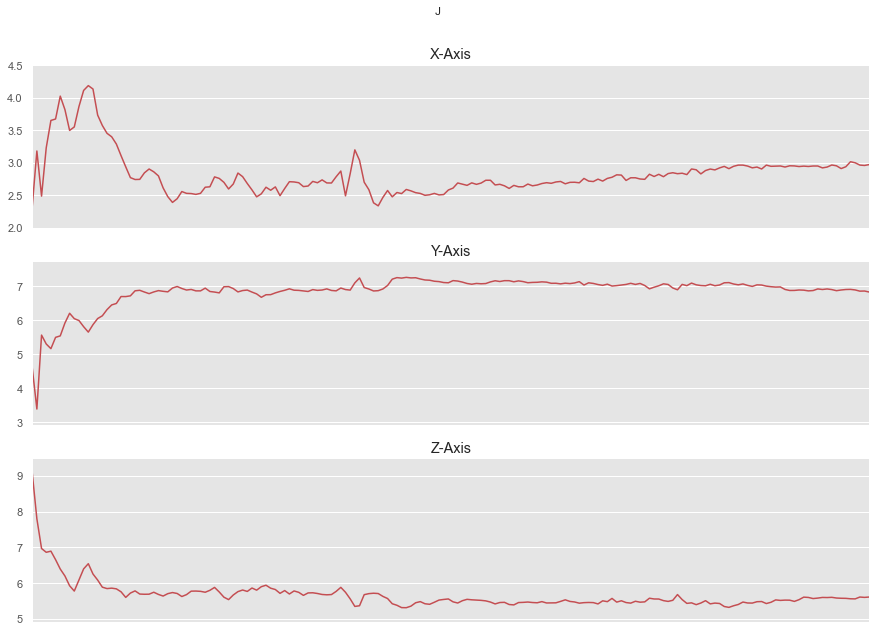

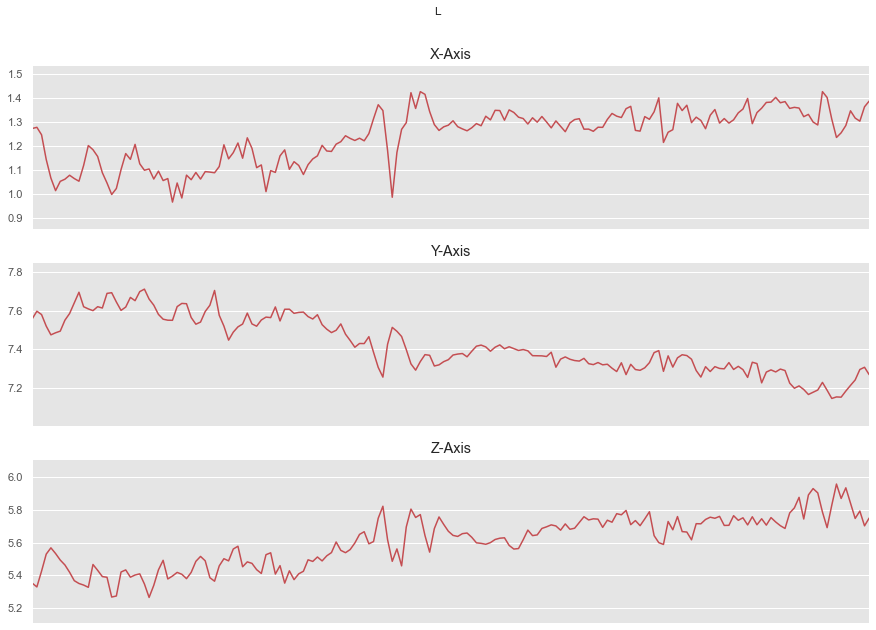

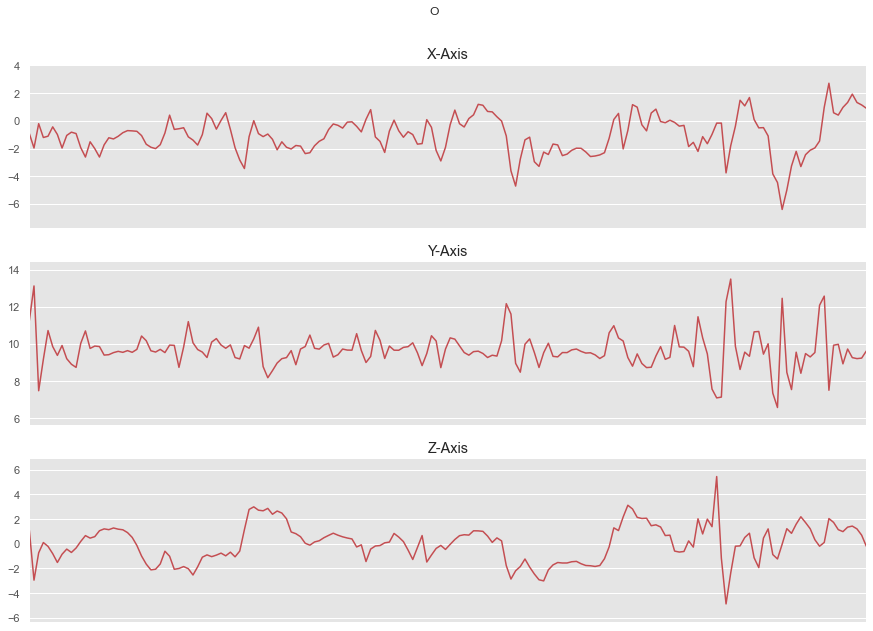

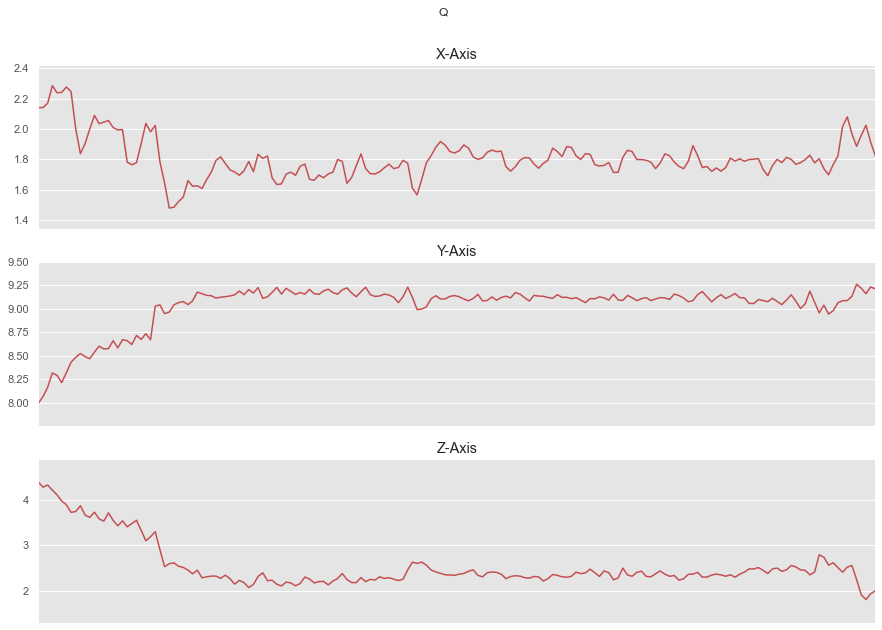

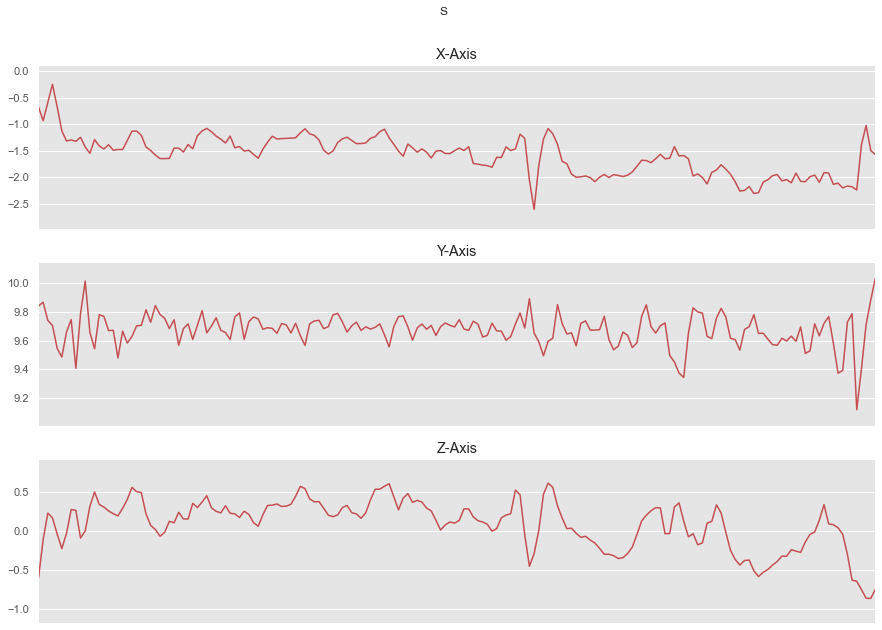

In [ ]:
new_activity= ['B','D','F','H','J','L','O','Q','S']


df_new = df[  (df['activity']=='B') | (df['activity']=='D') | (df['activity']=='F')
             | (df['activity']=='H') | (df['activity']=='J') | (df['activity']=='L')
             | (df['activity']=='O') | (df['activity']=='Q') | (df['activity']=='S')]
le = labelenocoder(df_new)

In [ ]:
X_train_new,y_train_new = spliting_dataset(df_new)

X_train Shape: (59089, 80, 3)
59089 training samples
y_train shape:  (59089,)
input_shape: 240


In [ ]:
num_time_periods, num_sensors = X_train_new.shape[1], X_train_new.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['B', 'D', 'F', 'H', 'J', 'L', 'O', 'Q', 'S']


In [ ]:
def comparison_with_size_dataset(df_new,size):
    X_train_new,y_train_new = spliting_dataset(df_new,size)
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)
    y_train_hot,y_test_hot,y_val_hot =  y_train_set(y_train_new,y_test_new,y_val_new)
    start = time.time()
    model_b = tf.keras.models.load_model('base_model_lstm.h5')
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history_new = model_b.fit(X_train_new,y_train_hot,batch_size=64,validation_data=(X_val_new, y_val_hot),verbose=1,
                        callbacks=[callback],epochs=60)
    stop= time.time()
    return stop-start,history_new.history, X_train_new.shape[0], X_val_new.shape[0]

In [ ]:
rates = 2
total_samples = 50
times_size,histories,train_sizes,val_sizes = list(), list(), list(),list()
subjects_id =1600
i= int(50/rates)
while(i<50 or i>0):
    t,h, train_size, val_size = comparison_with_size_dataset(df_new,subjects_id+i)
    times_size.append(t)
    histories.append(h)
    train_sizes.append(train_size)
    val_sizes.append(val_size)
    i = int(i/2)
    print(t,h['accuracy'][-1],train_size, val_size)

X_train Shape: (25629, 80, 3)
25629 training samples
y_train shape:  (25629,)
input_shape: 240
New y_train shape:  (16402, 9)
New y_train shape:  (5126, 9)
New y_train shape:  (4101, 9)
Train on 16402 samples, validate on 4101 samples
Epoch 1/60
16402/16402 [==============================] - 63s 4ms/sample - loss: 1.7858 - accuracy: 0.3483 - val_loss: 1.4195 - val_accuracy: 0.4665
Epoch 2/60
16402/16402 [==============================] - 63s 4ms/sample - loss: 1.3913 - accuracy: 0.4609 - val_loss: 1.2363 - val_accuracy: 0.5372
Epoch 3/60
16402/16402 [==============================] - 63s 4ms/sample - loss: 1.2558 - accuracy: 0.5272 - val_loss: 1.0883 - val_accuracy: 0.5930
Epoch 4/60
16402/16402 [==============================] - 63s 4ms/sample - loss: 1.1183 - accuracy: 0.5876 - val_loss: 1.0402 - val_accuracy: 0.6272
Epoch 5/60
16402/16402 [==============================] - 63s 4ms/sample - loss: 1.0272 - accuracy: 0.6295 - val_loss: 0.8958 - val_accuracy: 0.6940
Epoch 6/60
16402/164

KeyboardInterrupt: 

In [ ]:
print(np.asarray(histories).shape)

(23,)


In [ ]:
accuracy_s = list()
val_s = list()
for i in range(23):
    accuracy_s.append(histories[i]['accuracy'][-1])
    val_s.append(histories[i]['val_accuracy'][-1])

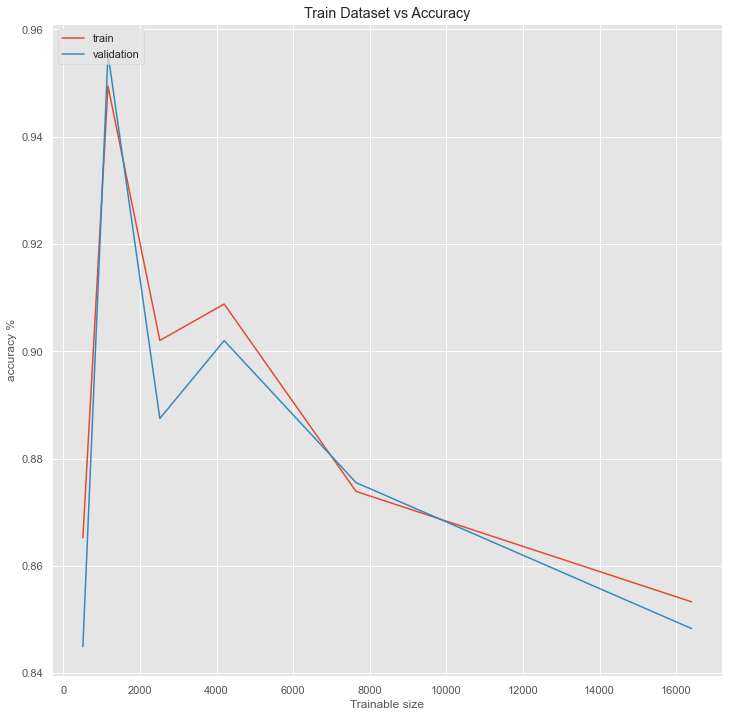

In [ ]:
fig = plt.figure(figsize=(12,12))
# summarize history for accuracy

plt.plot(train_sizes[0:6],accuracy_s[0:6])
plt.plot(train_sizes[0:6],val_s[0:6])
# plt.plot(history.history['val_acc'])

plt.title('Train Dataset vs Accuracy')
plt.ylabel('accuracy %')
plt.xlabel('Trainable size')
plt.legend(['train','validation'], loc='upper left')

fig.savefig('accuracyplottraindatasetvsaccuracy.png')
plt.show()

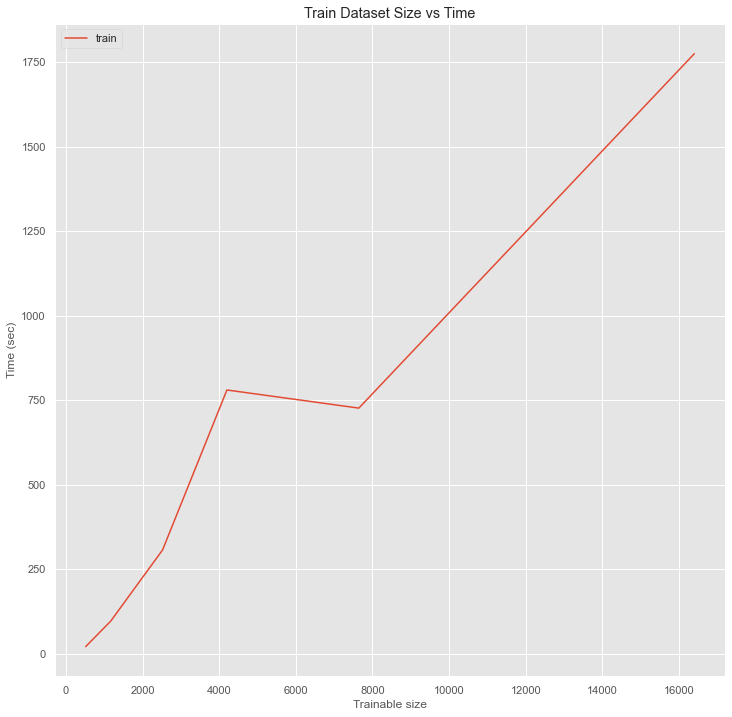

In [ ]:
fig = plt.figure(figsize=(12,12))
# summarize history for accuracy

plt.plot(train_sizes[0:6],times_size[0:6])


plt.title('Train Dataset Size vs Time')
plt.ylabel('Time (sec)')
plt.xlabel('Trainable size')
plt.legend(['train','validation'], loc='upper left')

fig.savefig('timeplottraindatasetvsaccuracy.png')
plt.show()

In [ ]:
def eval_transfer_model(X_train, X_test, y_train, y_test, number_layers=[], n_repeats=1):
    scores = list()
    times = list()
    layers = list()
    
    for _ in range(n_repeats):
    # load model
        model_b = tf.keras.models.load_model('base_model_lstm.h5')
        # mark layer weights as fixed or not trainable
        
        for j in number_layers:
            model_b.layers[j].trainable = False
       
        trainable_count = count_params(model_b.trainable_weights)
        non_trainable_count = count_params(model_b.non_trainable_weights)
        print(non_trainable_count)
        start = time.time()
       
        callback = CustomCallback()
        history_new = model_b.fit(X_train_new,y_train_hot,batch_size=64,validation_data=(X_val_new, y_val_hot),verbose=1,
                        callbacks=[callback],epochs=60)
        stop= time.time()
        # evaluate model on test dataset
        _, test_acc = model_b.evaluate( X_test, y_test, verbose=0,callbacks=[callback])
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times,trainable_count

In [ ]:
n_repeats = 1
dists, dist_labels,durations,trainable_count_all = list() ,list(), list(),list()

In [ ]:
n_fixed = 8
n_repeats = 1
number_layers = [1,2,3,4,5]
X_train_new,y_train_new = spliting_dataset(df_new,1603)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)
y_train_hot,y_test_hot,y_val_hot =  y_train_set(y_train_new,y_test_new,y_val_new)



X_train Shape: (3941, 80, 3)
3941 training samples
y_train shape:  (3941,)
input_shape: 240
New y_train shape:  (2521, 9)
New y_train shape:  (789, 9)
New y_train shape:  (631, 9)


In [ ]:
n_repeats = 1
dists, dist_labels,durations,trainable_count_all = list() ,list(), list(),list()

In [ ]:
i = list(range(9))
for j in i:
    number_layers = list(range(j))
    scores,times,trainable = eval_transfer_model(X_train_new,  X_test_new, y_train_hot, y_test_hot , number_layers, n_repeats)
    dists.append(scores)
    dist_labels.append('transfer f='+str(i))
    durations.append(times)
    trainable_count_all.append(trainable)

256
Train on 2521 samples, validate on 631 samples
Epoch 1/60
2521/2521 [==============================] - 19s 8ms/sample - loss: 2.2319 - accuracy: 0.3332 - val_loss: 1.3752 - val_accuracy: 0.4469
Epoch 2/60
2521/2521 [==============================] - 20s 8ms/sample - loss: 1.1662 - accuracy: 0.5811 - val_loss: 0.9627 - val_accuracy: 0.7211
Epoch 3/60
2521/2521 [==============================] - 19s 7ms/sample - loss: 0.9229 - accuracy: 0.6501 - val_loss: 0.7710 - val_accuracy: 0.7306
Epoch 4/60
2521/2521 [==============================] - 19s 7ms/sample - loss: 0.7579 - accuracy: 0.7247 - val_loss: 0.6213 - val_accuracy: 0.8051
Epoch 5/60
2521/2521 [==============================] - 19s 7ms/sample - loss: 0.5890 - accuracy: 0.7806 - val_loss: 0.4259 - val_accuracy: 0.8431
Epoch 6/60
2521/2521 [==============================] - 18s 7ms/sample - loss: 0.4817 - accuracy: 0.8148 - val_loss: 0.3717 - val_accuracy: 0.8621
Epoch 7/60
2521/2521 [==============================] - 19s 7ms/sam

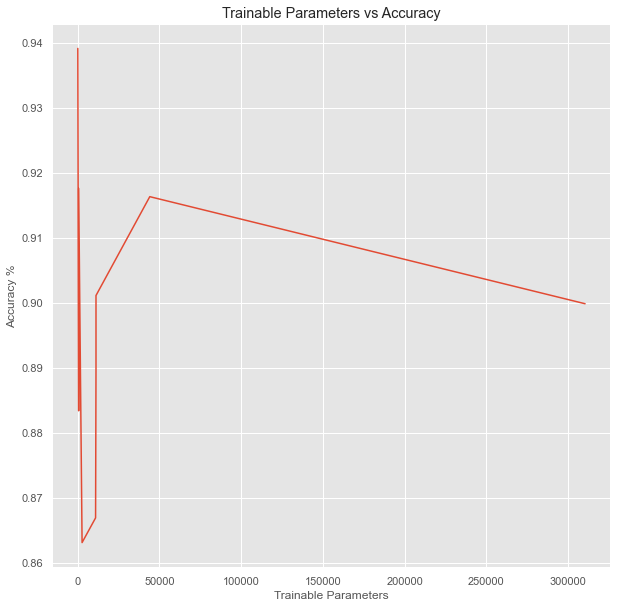

In [ ]:
fig = plt.figure(figsize=(10,10))
# summarize history for accuracy

plt.plot(trainable_count_all,dists)


plt.title('Trainable Parameters vs Accuracy')
plt.ylabel('Accuracy %')
plt.xlabel('Trainable Parameters')


fig.savefig('trainableparametersvsaccuracy.png')
plt.show()

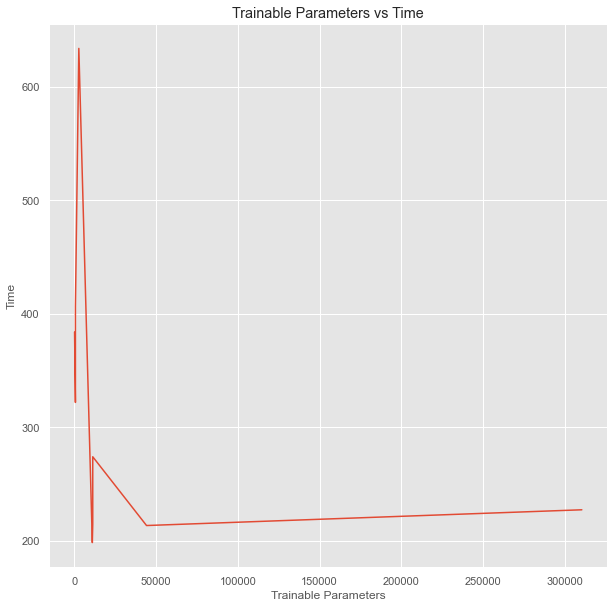

In [ ]:
fig = plt.figure(figsize=(10,10))
# summarize history for accuracy

plt.plot(trainable_count_all,durations)


plt.title('Trainable Weights s vs Time')
plt.ylabel('Time')
plt.xlabel('Trainable Weights')


fig.savefig('trainableparametersvstime.png')
plt.show()

In [ ]:
X_train_new,y_train_new = spliting_dataset(df_new,1603)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)
y_train_hot,y_test_hot,y_val_hot =  y_train_set(y_train_new,y_test_new,y_val_new)

model_b = tf.keras.models.load_model('base_model_lstm.h5')
        # mark layer weights as fixed or not trainable
        
for j in range(9):
    model_b.layers[j].trainable = False
       
trainable_count = count_params(model_b.trainable_weights)
non_trainable_count = count_params(model_b.non_trainable_weights)
print(trainable_count)
start = time.time()
       
callback = CustomCallback()
history_new = model_b.fit(X_train_new,y_train_hot,batch_size=64,validation_data=(X_val_new, y_val_hot),verbose=1,
                        callbacks=[callback],epochs=60)
stop= time.time()
        # evaluate model on test dataset
_, test_acc = model_b.evaluate( X_test_new, y_test_hot, verbose=0,callbacks=[callback])


X_train Shape: (3941, 80, 3)
3941 training samples
y_train shape:  (3941,)
input_shape: 240
New y_train shape:  (2521, 9)
New y_train shape:  (789, 9)
New y_train shape:  (631, 9)
0
Train on 2521 samples, validate on 631 samples
Epoch 1/60
2521/2521 [==============================] - 22s 9ms/sample - loss: 2.3201 - accuracy: 0.2991 - val_loss: 1.6297 - val_accuracy: 0.3344
Epoch 2/60
2521/2521 [==============================] - 21s 9ms/sample - loss: 1.5629 - accuracy: 0.3887 - val_loss: 1.4338 - val_accuracy: 0.4390
Epoch 3/60
2521/2521 [==============================] - 21s 8ms/sample - loss: 1.3039 - accuracy: 0.4760 - val_loss: 1.2071 - val_accuracy: 0.5198
Epoch 4/60
2521/2521 [==============================] - 21s 8ms/sample - loss: 1.1535 - accuracy: 0.5415 - val_loss: 1.0283 - val_accuracy: 0.6212
Epoch 5/60
2521/2521 [==============================] - 22s 9ms/sample - loss: 0.9264 - accuracy: 0.6565 - val_loss: 0.8039 - val_accuracy: 0.6926
Epoch 6/60
2521/2521 [==============

ValueError: Input arrays should have the same number of samples as target arrays. Found 12204 input samples and 789 target samples.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


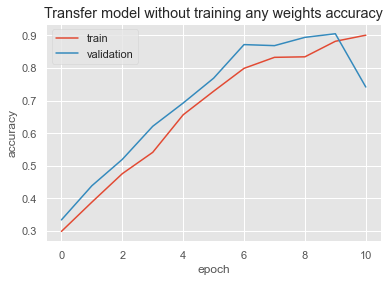

In [ ]:
print(history_new .history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history_new .history['accuracy'])
plt.plot(history_new .history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('Transfer model without training any weights accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy_lstm.png')
plt.show()